# Generates the Reward Data for Cartpole2

In [7]:
import math
from importlib import reload
import os

import gc
import matplotlib.pyplot as plt
import pickle
import numpy as np

from tqdm.notebook import tqdm

from adaptive_time import plot_utils
from adaptive_time import utils
from adaptive_time import run_lib
from adaptive_time.environments import cartpole2
from adaptive_time import value_est
from adaptive_time.value_est import approx_integrators

from pprint import pprint

approx_integrators = reload(approx_integrators)
run_lib = reload(run_lib)
cartpole2 = reload(cartpole2)
value_est = reload(value_est)
plot_utils = reload(plot_utils)
utils = reload(utils)

/Users/szepi1991/Code/adaptive_time/.venv/lib/python3.11/site-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment CartPole-OURS-v2 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


In [8]:
utils.set_directory_in_project()

Changed working directory to /Users/szepi1991/Code/adaptive_time


'/Users/szepi1991/Code/adaptive_time'

In [9]:

SHOULD_TERMINATE = True
discrete_reward = True
GRAB_DETAILED_DATA = False


In [10]:
seed = 13
dt_scaler = 200.
new_dt = 0.02 / dt_scaler
STEPS_MAX = 20_000
STEPS_BREAK_FROM = 9_000

# NUM_TRAJS = 2
NUM_TRAJS = 100


In [11]:

if discrete_reward:
    reward_type = "discrete"
else:
    reward_type = "continuous"


BASE_DIR = "classic_control_data"
data_descr = f"cartpole2_rew_{reward_type}_term{SHOULD_TERMINATE}"
traj_data_file = f"{data_descr}.pkl"



In [12]:
utils.set_directory_in_project()
traj_data_path = os.path.join(BASE_DIR, traj_data_file)

from adaptive_time import mc2
import adaptive_time.utils
import gymnasium as gym
import random

env = gym.make(
    'CartPole-OURS-v2',
    discrete_reward=discrete_reward,
    should_terminate=SHOULD_TERMINATE,
    step_time=new_dt)
_NUM_ACTIONS = 2

phi = run_lib.make_features()

weights_good_policy = np.load("cartpole_weights_20240227-102913_ret92516.44719752521.npy")
# weights_good_policy = np.load("cartpole_weights_20240227-102913_ret50756.37604280466.npy")

def policy(state, num_step, weights, epsilon):
    if num_step >= STEPS_BREAK_FROM:
        # if random.random() < 0.95:  # spread of 60 at 100 trajs
        # if random.random() < 0.55:  # a nice spread
        return 0   # Alway push in one direction.

    if random.random() < epsilon:
        action = env.action_space.sample()
        return action

    # Otherwise calculate the best action.
    x = phi.get_fourier_feature(state)
    qs = np.zeros(_NUM_ACTIONS)
    for action in range(_NUM_ACTIONS):
        x_sa = mc2.phi_sa(x, action)
        qs[action] = np.inner(x_sa.flatten(), weights)
    # adaptive_time.utils.softmax(qs, 1)
    
    return adaptive_time.utils.argmax(qs)

run_lib.reset_randomness(seed, env)

def _random_start_state(num):
    rand = np.random.standard_normal((num, 4))
    # rand *= np.array([[0.01, 0.01, 0.005, 0.002]])
    rand *= np.array([[0.01, 0.01, 0.005, 0.002]])
    return rand

start_states = _random_start_state(NUM_TRAJS)
print("shape", start_states.shape)
print("max", np.max(start_states, axis=0))

total_rewards = []
reward_sequences = []
traj_lengths = []
angles = []
xs = []
d_angles = []
actions = []
dxs = []
for idx in tqdm(range(NUM_TRAJS)):
    start_state = tuple(start_states[idx])
    # Tuple[float, float, float, float]
    trajectory, early_term = value_est.generate_trajectory(
            env, start_state=start_state,
            policy=lambda st, sn: policy(st, sn, weights_good_policy, 0.0),
            # policy=policy,
            termination_prob=0.0, max_steps=STEPS_MAX)

    traj_lengths.append(len(trajectory))
    rewards = [r for _, _, r, _ in trajectory]
    if GRAB_DETAILED_DATA:
        actions.append([a for _, a, _, _ in trajectory])
        xs.append([s[0] for s, _, _, _ in trajectory])
        angles.append([s[2] for s, _, _, _ in trajectory])
        d_angles.append([s[3] for s, _, _, _ in trajectory])
        dxs.append([s[1] for s, _, _, _ in trajectory])
    reward_sequences.append(rewards)
    total_rewards.append(sum(rewards))

total_rewards = np.array(total_rewards)
# Reward sequences may be different lengths in the terminating
# case, so we can't make a 2D array.
if not SHOULD_TERMINATE:
    reward_sequences = np.array(reward_sequences)
    traj_lengths = np.array(traj_lengths)
    angles = np.array(angles)
    xs = np.array(xs)
    d_angles = np.array(d_angles)
    actions = np.array(actions)
    dxs = np.array(dxs)

if GRAB_DETAILED_DATA:
    details = (angles, xs, d_angles, actions, dxs)
else:
    details = None
all_traj_data = (
    total_rewards, reward_sequences, traj_lengths,
    details
)
with open(traj_data_path, "wb") as f:
    pickle.dump(all_traj_data, f)
print("Saved data to", traj_data_path)

print(env.tau)


print("total_rewards for each traj:", total_rewards)
if hasattr(reward_sequences, "shape"):
    print("all rewards shape if array:", reward_sequences.shape)
num_trajs = len(total_rewards)

shape (100, 4)
max [0.01849613 0.03401106 0.01296042 0.00477349]


  0%|          | 0/100 [00:00<?, ?it/s]

/Users/szepi1991/Code/adaptive_time/.venv/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:181: DeprecationWarning: WARN: Current gymnasium version requires that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.deprecation(
/Users/szepi1991/Code/adaptive_time/.venv/lib/python3.11/site-packages/gymnasium/spaces/box.py:240: UserWarning: WARN: Casting input x to numpy array.
  gym.logger.warn("Casting input x to numpy array.")


Saved data to classic_control_data/cartpole2_rew_discrete_termTrue.pkl
0.0001
total_rewards for each traj: [10723. 10708. 10726. 10715. 10713. 10716. 10736. 10717. 10724. 10731.
 10725. 10725. 10718. 10713. 10719. 10742. 10723. 10726. 10731. 10727.
 10728. 10738. 10738. 10707. 10733. 10734. 10735. 10729. 10718. 10723.
 10718. 10724. 10724. 10723. 10718. 10727. 10724. 10717. 10726. 10724.
 10731. 10725. 10728. 10716. 10725. 10728. 10719. 10719. 10734. 10722.
 10725. 10715. 10732. 10732. 10736. 10719. 10715. 10721. 10730. 10730.
 10731. 10720. 10723. 10730. 10721. 10716. 10729. 10720. 10741. 10709.
 10727. 10708. 10723. 10722. 10716. 10714. 10728. 10723. 10707. 10728.
 10708. 10718. 10728. 10716. 10713. 10715. 10725. 10730. 10729. 10720.
 10718. 10722. 10724. 10731. 10723. 10730. 10735. 10722. 10713. 10706.]


/Users/szepi1991/Code/adaptive_time/.venv/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.tau to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.tau` for environment variables or `env.get_wrapper_attr('tau')` that will search the reminding wrappers.
  logger.warn(


In [13]:
support_dir = os.path.join(BASE_DIR, "reward_info")
utils.set_directory_in_project(support_dir, create_dirs=True)
# utils.set_directory_in_project(BASE_DIR, create_dirs=True)  # Just to make the dir.
# utils.set_directory_in_project()


Changed working directory to /Users/szepi1991/Code/adaptive_time/classic_control_data/reward_info


'/Users/szepi1991/Code/adaptive_time/classic_control_data/reward_info'

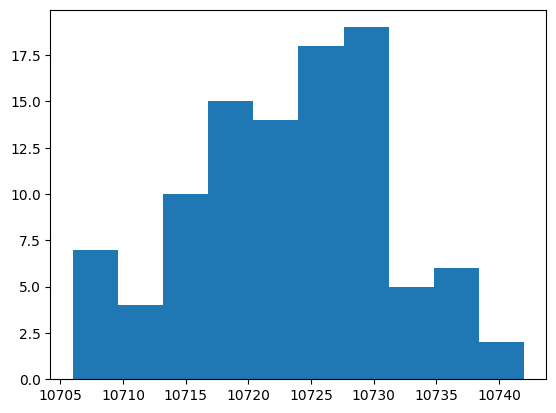

In [14]:
plt.hist(total_rewards)
plt.savefig(f'{data_descr}_reward_total_distr.png')

10723.0


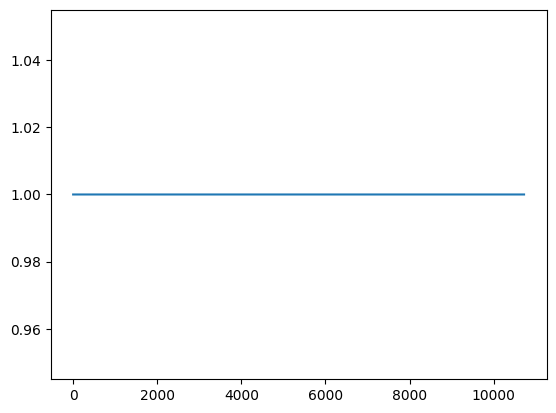

In [15]:

traj_idx = 0
print(total_rewards[traj_idx])
plt.plot(reward_sequences[traj_idx])
plt.savefig(f'{data_descr}_reward_sample_curve.png')